<a href="https://colab.research.google.com/github/gauravk268/HackerEarth-Emotion-Detection-Tom-Jerry-Cartoon/blob/master/hackerearth_deep_learning_challenge_emotion_detection_tom_jerry_cartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem & Dataset

Problem: https://www.hackerearth.com/challenges/competitive/hackerearth-deep-learning-challenge-emotion-detection-tom-jerry-cartoon/

In [1]:
#importing libraries

import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
import tensorflow as tf
import os
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# #code for sampling image from the video @ 5fps
# #to be used only once for sampling video

# count = 0
# videoFile = "https://drive.google.com/open?id=1ru9a2wbKGXCaWM9cdmbw7aIS4lNFT9tP"
# cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
# frameRate = cap.get(5) #frame rate
# x=1

# while(cap.isOpened()):
#     frameId = cap.get(1) #current frame number
#     ret, frame = cap.read()
#     cv2.imshow("Sample", frame)
#     if (ret != True):
#         break
#     if (frameId % math.floor(frameRate) == 0):
#         filename ="/content/drive/My Drive/Colab Notebooks/Sampled_Image_Train/frame%d.jpeg" % count;count+=1
#         count+=1
#         cv2.imwrite(filename, frame)
#         print("*", end="")
    
# cap.release()
# cv2.destroyAllWindows()
# print ("Done!")

In [0]:
#changing path to the sampled image folder

PATH_OF_TRAIN_IMAGE= '/content/drive/My\ Drive/Colab\ Notebooks/Sampled_Image_Train'

In [4]:
cd {PATH_OF_TRAIN_IMAGE}

/content/drive/My Drive/Colab Notebooks/Sampled_Image_Train


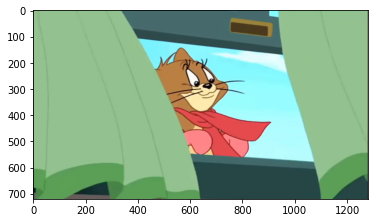

In [5]:
img = plt.imread('frame0.jpg')   # reading image using its name
plt.imshow(img)

In [0]:
#loading training data

cols_list = ["Frame_ID", "Emotion"]

data = pd.read_csv("Copy of Train.csv", usecols=cols_list)

In [0]:
X = []
for img_name in data["Frame_ID"]:
    img = plt.imread("" + img_name)
    X.append(img)

X = np.array(X)

In [0]:
'''

1 Angry
2 Happy
3 Sad
4 Surprised
5 Unknown

'''


y = []

value = 0

for i in data["Emotion"]:
    if i == 'angry':
        value = 1
    if i == 'happy':
        value = 2
    if i == 'sad':
        value = 3
    if i == 'surprised':
        value = 4
    if i == 'unknown':
        value = 5

    y.append(value)

dummy_y = np_utils.to_categorical(y)

In [0]:
#reshaping images to 224*224*3 to be used for VGG16 pretrained model

image = []

for i in range(0, X.shape[0]):

    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)
    image.append(a)

X = np.array(image)

In [0]:
#before passing any input to the model, we must preprocess it as per the model’s requirement

from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')


In [0]:
# splitting the set of training examplws into training and validation set
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, dummy_y, test_size = 0.3, random_state = 42)

In [12]:
!pip install tensorflow==1.14.0     

from keras.models import Sequential     # https://keras.io/getting-started/sequential-model-guide/
from keras.applications.vgg16 import VGG16  # https://keras.io/applications/
from keras.layers import Dense, InputLayer, Dropout 

In [13]:
# now loading the VGG16 pretrained model and store it as base_model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# include_top=False to remove the top layer





58892288/58889256 [==============================] - 5s 0us/step




In [14]:
#  make predictions using this model for X_train and X_valid, get the features, and then using those features to retrain the model

X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)

X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

In [0]:
#  In order to pass it to our neural network, we have to reshape it to 1-D

X_train = X_train.reshape(208, 7*7*512)
X_valid = X_valid.reshape(90, 7*7*512)

In [0]:
# preprocess the images and make them zero-centered which helps the model to converge faster.

train = X_train / X_train.max()
X_valid = X_valid / X_train.max()

In [0]:
'''

Finally, we will build our model. This step can be divided into 3 sub-steps:

Building the model
Compiling the model
Training the model

'''

# Building the model

model = Sequential()
model.add(InputLayer((7*7*512, )))
model.add(Dense(units = 1024, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 25,696,261
Trainable params: 25,696,261
Non-trainable params: 0
_________________________________________________________________


In [19]:
# compiling the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# training the model

model.fit(train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 3s 16ms/step - loss: 1.4611 - acc: 0.3990 - val_loss: 1.2238 - val_acc: 0.4333
Epoch 2/100
208/208 [==============================] - 3s 12ms/step - loss: 0.7021 - acc: 0.6971 - val_loss: 1.2725 - val_acc: 0.5111
Epoch 3/100
208/208 [==============================] - 3s 12ms/step - loss: 0.4824 - acc: 0.8462 - val_loss: 1.0073 - val_acc: 0.6000
Epoch 4/100
208/208 [==============================] - 3s 12ms/step - loss: 0.3387 - acc: 0.8750 - val_loss: 1.0342 - val_acc: 0.6778
Epoch 5/100
208/208 [==============================] - 3s 12ms/step - loss: 0.2250 - acc: 0.9423 - val_loss: 1.0342 - val_acc: 0.6667
Epoch 6/100
208/208 [==============================] - 3s 12ms/step - loss: 0.1706 - acc: 0.9663 - val_loss: 1.0334 - val_acc: 0.6667
Epoch 7/100
208/208 [==============================] - 3s

In [26]:
cd ../

/content/drive/My Drive/Colab Notebooks


In [27]:
cd TEST

/content/drive/My Drive/Colab Notebooks/TEST


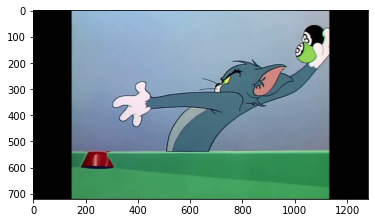

In [29]:
img = plt.imread('test0.jpg')   # reading image using its name
plt.imshow(img)

In [0]:
cols_list = ["Frame_ID", "Emotion"]

test = pd.read_csv("Test.csv")



In [31]:
test.head()

,Frame_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg


In [0]:
test_image = []
for img_name in test["Frame_ID"]:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [0]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [40]:
print(np.shape(test_image))

(186, 224, 224, 3)


In [0]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [0]:
prediction = model.predict_classes(test_image)

In [56]:
prediction

array([4, 4, 4, 4, 1, 4, 4, 2, 2, 2, 4, 4, 1, 1, 4, 4, 2, 2, 4, 4, 2, 2,
       2, 2, 1, 4, 2, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 4, 1, 1, 4, 4, 4,
       4, 4, 4, 4, 2, 4, 1, 1, 1, 4, 4, 4, 1, 2, 2, 2, 2, 1, 4, 4, 4, 4,
       4, 2, 4, 1, 1, 4, 4, 4, 4, 1, 4, 1, 2, 4, 1, 1, 1, 3, 4, 1, 1, 2,
       2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 2, 2, 4, 4, 2, 1,
       2, 4, 2, 2, 2, 4, 2, 1, 2, 2, 1, 4, 4, 4, 1, 4, 4, 4, 1, 4, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 1, 4, 1, 4, 4,
       4, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1,
       4, 4, 4, 4, 4, 4, 4, 3, 1, 1])

In [0]:
'''

1 Angry
2 Happy
3 Sad
4 Surprised
5 Unknown

'''
emotion = ''
result = []
for i in prediction:
    if i == 1:
        emotion = 'angry'
    if i == 2:
        emotion = 'happy'
    if i == 3:
        emotion = 'sad'
    if i == 4:
        emotion = 'surprised'
    if i == 5:
        emotion = 'unknown'

    result.append(emotion)


In [0]:
test["Emotion"] = result

In [59]:
test.head()

,Frame_ID,Emotion
0,test0.jpg,surprised
1,test1.jpg,surprised
2,test2.jpg,surprised
3,test3.jpg,surprised
4,test4.jpg,angry


In [0]:
my_df = pd.DataFrame(test)
my_df.to_csv('Test.csv', index=False, header=False)